In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim
import torch.nn.functional as F
import random
#from google.colab import drive
#drive.mount('/content/drive')
#sys.path.insert(0,'/content/drive/MyDrive/road_seg')

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")  

In [4]:

class RSDataset(Dataset):
    def __init__(self, root_dir):
        self.image_dir = root_dir + "images/"
        self.gt_dir = root_dir + "groundtruth/"
        self.root_dir = root_dir
        self.imgs = os.listdir(self.image_dir)
        self.gt = os.listdir(self.gt_dir)
        self.gt.sort()
        self.imgs.sort()
        self.size = len(self.imgs)
    
    def __len__(self):
        return self.size

    def __getitem__(self,index):
        n = "{0:0=3d}".format(index)
        filename = "satImage_"+n+".png"

        #image processing
        img = mpimg.imread(self.image_dir + self.imgs[index])
        img = torch.tensor(img).permute(2,0,1)
        img = img.to(device)

        #mask processing
        gt_img = mpimg.imread(self.gt_dir + self.gt[index])
        gt_img = torch.tensor(gt_img)
        gt_img[gt_img < 0.5] = 0
        gt_img[gt_img > 0.5] = 1
        gt_img = gt_img.to(device)

        return {
            'image': img,
            'target': gt_img
        }

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

In [7]:
# Loaded a set of images
root_dir = "training/"

dataset = RSDataset(root_dir)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [8]:
class DoubleConv(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(DoubleConv, self).__init__()
    self.layer =  nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size = 3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(True),
        nn.Conv2d(out_channel, out_channel, kernel_size = 3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(True)
    )

  def forward(self,x):
    return self.layer(x)

class Down(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(Down, self).__init__()

    self.layer = nn.Sequential(
      nn.MaxPool2d(kernel_size = 2),
      DoubleConv(in_channel, out_channel)
  )
    
  def forward(self,x):
    return self.layer(x)

class Up(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(Up, self).__init__()
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.conv = DoubleConv(in_channel, out_channel)
    
  def forward(self, x1, x2):
      x2 = self.upsample(x2)

      diffX = x1.shape[2] - x2.shape[2]
      diffY = x1.shape[3] - x2.shape[3]
      x1 = x1[:,:, diffX // 2 : x1.shape[2] - diffX // 2 - diffX % 2,:]
      x1 = x1[:,:,:, diffY // 2 : x1.shape[3] - diffY // 2 - diffY % 2]
      x = torch.cat([x1,x2], axis = 1)
      return self.conv(x)


class Unet(nn.Module):
    def __init__(self, output_channel):
        super(Unet, self).__init__()
        #_LEFT
        self.conv1 = DoubleConv(3,64)
        self.down2 = Down(64,128)
        self.down3 = Down(128,256)
        self.down4 = Down(256,512)
        self.down5 = Down(512,1024)
        
        
        #RIGHT  
        self.up6 = Up(1024+512,512)
        self.up7 = Up(512+256,256)
        self.up8 = Up(256+128,128)
        self.up9 = Up(128+64,64)
        
        #layer to match input size
        self.outConv1 = nn.Conv2d(64,64, kernel_size= 13)
        self.outConv = nn.Conv2d(64, output_channel, kernel_size = 1)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self,x):
        #DOWN DIRECTION
        x1 = self.conv1(x)
        
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x = self.down5(x4)
        
        #UP DIRECTION
        x = self.up6(x4, x)
        x = self.up7(x3, x)
        x = self.up8(x2, x)
        x = self.up9(x1, x)
        
        x = self.outConv1(x)
        x = self.outConv(x)
        x = self.up(x)
        
        return x

In [9]:
def visualize(model, idx, threshold):
    with torch.no_grad():
      prediction = model(dataset[idx]["image"].view(1,3,400,400))

    prediction = torch.sigmoid(prediction).squeeze(1).to(torch.device("cpu"))
    prediction[prediction > threshold] = 1
    prediction[prediction < threshold] = 0
    prediction = prediction[0].detach().numpy()
    input = dataset[idx]["image"].to(torch.device("cpu")).permute(1,2,0).numpy()
    target = dataset[idx]["target"].to(torch.device("cpu")).numpy()
    print(input.shape)

    cimg = concatenate_images(input,prediction)
    cimg = concatenate_images(cimg,target)
    fig1 = plt.figure(figsize=(10, 10))
    plt.imshow(cimg, cmap='Greys_r')

In [10]:
def trainModel(model, criterion, optimizer, epoch, loader): 
    model = model.to(device)
    print("TRAINING")
    print("EPOCH : TOT_LOSS")
    for e in range(epoch):
        sum_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            prediction = model(batch["image"])
            prediction = prediction.squeeze(1)
            loss = criterion(prediction, batch["target"])
            nn.utils.clip_grad_value_(model.parameters(), 0.1)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            #print("End of sample")
        print("{:5} {:>10.4f}".format(e, sum_loss))

In [11]:
model = Unet(output_channel=1).to(device)
#model.load_state_dict(torch.load("model.PTH"))

In [12]:
lr = 10e-4
nb_epoch = 5
batch_size = 1
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr)

trainModel(model,criterion, optimizer, nb_epoch, loader)
torch.save(model.state_dict, "model.PTH")

TRAINING
EPOCH : TOT_LOSS


KeyboardInterrupt: 

(400, 400, 3)


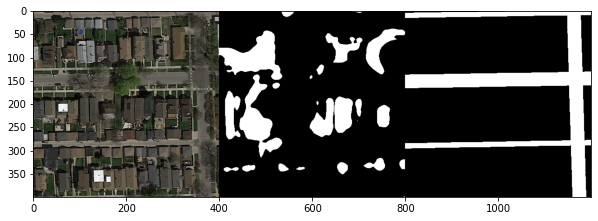

In [251]:
visualize(model,54, 0.3)

In [236]:
dataset.imgs[54]

'satImage_055.png'

In [237]:
dataset.gt[54]

'satImage_055.png'